In [8]:
import pandas as pd
import json
from collections import Counter
import random
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df = pd.read_parquet('GenericMixOfTopic.parquet')

In [ ]:
# Decode the topics_with_percentages column
def decode_topics(topics_bytes):
    return json.loads(topics_bytes.decode('utf-8'))

df['topics_with_percentages'] = df['topics_with_percentages'].apply(decode_topics)

In [12]:
from sklearn.model_selection import train_test_split

# Split the dataframe into train and test datasets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

# Print the shapes of the train and test datasets
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (100002, 5)
Test dataset shape: (100003, 5)


In [85]:
# Set the desired number of entries
N = 10000

In [86]:
# Step 2: Randomly downsample the dataset to have less random samples
downsampled_df = train_df[train_df["topic"] == "Mixed"].sample(n=N//10, random_state=42)
downsampled_df.reset_index(drop=True, inplace=True)
downsampled_df.head()

,id,title,topic,topics_with_percentages,text
0,35991735,Tezno massacre,Mixed,"{'History': 0.21, 'Human_behavior': 0.2, 'Mili...",The Tezno massacre ( ) was the mass killing ...
1,374385,Creative problem-solving,Mixed,"{'Human_behavior': 0.57, 'Academic_disciplines...",Creative problem-solving (CPS) is the mental...
2,71146009,MTA Records (American record label),Mixed,"{'Entities': 0.67, 'Culture': 0.11, 'Entertain...",For the British record label see MTA Records...
3,18675164,1st Mounted Rifles,Mixed,"{'Military': 0.67, 'History': 0.25, 'Time': 0....",The 1st Mounted Rifles (Canterbury Yeomanry ...
4,60147987,Sphaerodactylus poindexteri,Mixed,"{'Life': 0.61, 'Nature': 0.17, 'Geography': 0....",'Sphaerodactylus poindexteri' is a small spe...


Initial counts of non-null probabilities for each label:
Counter({'People': 476, 'History': 301, 'Entertainment': 289, 'Time': 239, 'Geography': 238, 'Mass_media': 226, 'Society': 222, 'Government': 206, 'Culture': 200, 'Sports': 189, 'Humanities': 152, 'Education': 143, 'Politics': 105, 'Business': 97, 'Technology': 95, 'Universe': 86, 'Life': 79, 'Human_behavior': 75, 'Military': 73, 'Economy': 72, 'Academic_disciplines': 71, 'Health': 69, 'Nature': 64, 'Entities': 62, 'Religion': 59, 'Science': 58, 'Law': 52, 'Engineering': 49, 'Knowledge': 34, 'Language': 34, 'Information': 31, 'Concepts': 23, 'Food_and_drink': 22, 'Energy': 12, 'Mathematics': 9, 'Internet': 8, 'Philosophy': 5, 'Communication': 5, 'Ethics': 3})


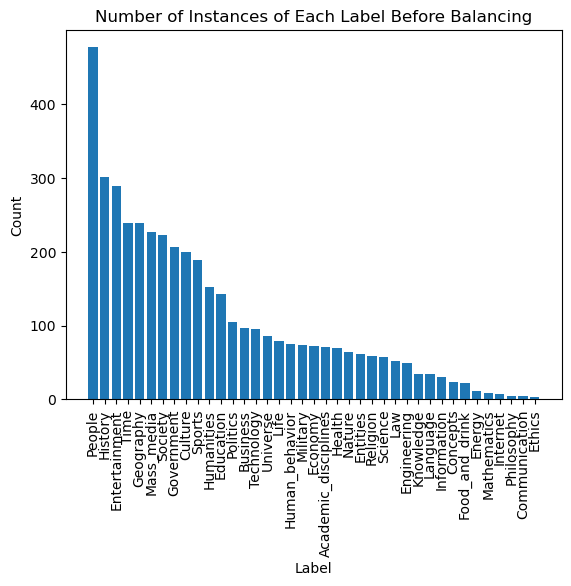

In [87]:
label_activation_threshold = 0

# Step 3: Count the occurrences of non-null probabilities for each label
def count_non_null_probabilities(df):
    counts = Counter()
    for topics in df['topics_with_percentages']:
        for topic, prob in topics.items():
            if prob > label_activation_threshold:
                counts[topic] += 1
    return counts

initial_counts = count_non_null_probabilities(downsampled_df)
print("Initial counts of non-null probabilities for each label:")
print(initial_counts)

# Plot the initial distribution
initial_labels, initial_counts_values = zip(*sorted(initial_counts.items(), key=lambda item: item[1], reverse=True))
plt.bar(initial_labels, initial_counts_values)
plt.title('Number of Instances of Each Label Before Balancing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



In [88]:
# Step 4: Take samples with probability of 1 for each label

# Create a new balanced dataframe
balanced_df = downsampled_df.copy()

# Calculate the remaining number of samples needed
remaining_samples_needed = N - len(balanced_df)

# Distribute the remaining samples among the rare labels first
rare_labels = [label for label, count in sorted(initial_counts.items(), key=lambda item: item[1])]

# Calculate the number of samples to be added per label
label_sample_size = max(remaining_samples_needed // len(rare_labels), 1)

230

In [101]:
remaining_samples_needed

30

Final counts of non-null probabilities for each label after balancing:
Counter({'People': 706, 'History': 531, 'Entertainment': 519, 'Time': 469, 'Geography': 468, 'Mass_media': 456, 'Society': 452, 'Government': 436, 'Culture': 430, 'Sports': 419, 'Humanities': 382, 'Education': 373, 'Politics': 335, 'Business': 327, 'Technology': 325, 'Universe': 316, 'Life': 309, 'Human_behavior': 305, 'Military': 303, 'Economy': 302, 'Academic_disciplines': 301, 'Health': 299, 'Nature': 294, 'Entities': 292, 'Religion': 289, 'Science': 288, 'Law': 282, 'Engineering': 279, 'Language': 264, 'Knowledge': 264, 'Information': 261, 'Concepts': 253, 'Food_and_drink': 252, 'Energy': 242, 'Mathematics': 239, 'Internet': 238, 'Communication': 235, 'Philosophy': 235, 'Ethics': 233})


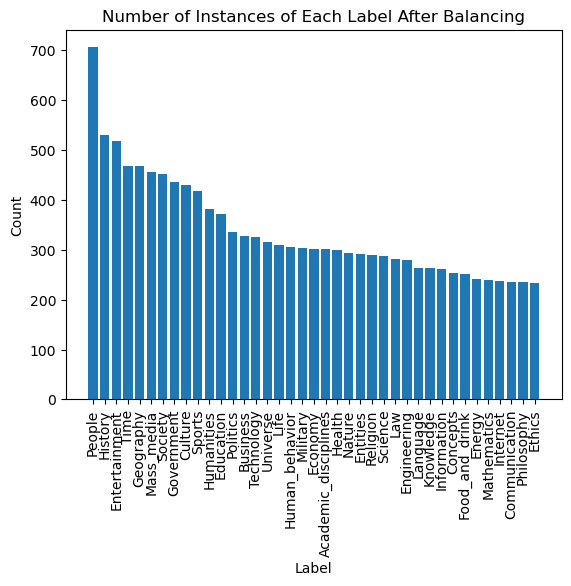

In [89]:
def get_samples_with_high_probability(df, label, sample_size):
    high_prob_samples = df[df['topics_with_percentages'].apply(lambda x: x.get(label, 0) == 1)]
    return high_prob_samples.sample(n=sample_size, replace=True, random_state=42)

one_topic_train_df = train_df[train_df['topic'] != 'Mixed']

# Step 5: Take additional samples for rare labels until N entries are reached
for label in rare_labels:
    if remaining_samples_needed <= 0:
        break
    samples = get_samples_with_high_probability(train_df, label, min(remaining_samples_needed, label_sample_size))
    balanced_df = pd.concat([balanced_df, samples])
    remaining_samples_needed -= len(samples)

# Ensure we do not exceed N entries
if len(balanced_df) > N:
    balanced_df = balanced_df.sample(n=N, random_state=42)
else:
    balanced_df = balanced_df.sample(n=len(balanced_df), random_state=42)

balanced_df.reset_index(drop=True, inplace=True)

# Verify the counts after balancing
final_counts = count_non_null_probabilities(balanced_df)
print("Final counts of non-null probabilities for each label after balancing:")
print(final_counts)

# Visualize the new distribution
final_labels, final_counts_values = zip(*sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
plt.bar(final_labels, final_counts_values)
plt.title('Number of Instances of Each Label After Balancing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [92]:
balanced_df.shape

(9970, 5)

In [94]:
balanced_df

,id,title,topic,topics_with_percentages,text
0,33934087,Mildiani,Language,"{'Language': 1.0, 'Academic_disciplines': 0, '...",Mildiani ( ) is a Georgia (country)|Georgian ...
1,43334541,Estaires (chicken),Food_and_drink,"{'Food_and_drink': 1.0, 'Academic_disciplines'...",The ( ) is a list of chicken breeds|breed of...
2,8818559,Hinduism in Belgium,Religion,"{'Religion': 1.0, 'Academic_disciplines': 0, '...",Hinduism is a minority religion in Belgium ....
3,37599712,1988 European Marathon Cup,Mixed,"{'Sports': 0.83, 'Geography': 0.17, 'Academic_...",The 1988 European Marathon Cup was the fourth...
4,3050422,Empiric therapy,Health,"{'Health': 1.0, 'Academic_disciplines': 0, 'Bu...",Empiric therapy or empirical therapy is medi...
...,...,...,...,...,...
9965,63745478,Maratha occupation of Kolistan (1672),Military,"{'Military': 1.0, 'Academic_disciplines': 0, '...",Maratha occupation of Kolistan ( ) in the ye...
9966,14696761,GJB6,Academic_disciplines,"{'Academic_disciplines': 1.0, 'Business': 0, '...","Gap junction beta-6 protein (GJB6), also kno..."
9967,18538373,Sunami Station,Economy,"{'Economy': 1.0, 'Academic_disciplines': 0, 'B...",Infobox station | name Sunami Station | nati...
9968,39375266,Big Town Czar,Mixed,"{'Mass_media': 0.58, 'Entertainment': 0.23, 'H...",'Big Town Czar' is a 1939 American mystery f...


In [96]:
column_unique_counts = balanced_df["id"].nunique()
print(column_unique_counts)

8569
